<a href="https://colab.research.google.com/github/vinodbiradar179-rgb/Calculator/blob/main/recipes/Time_Series/Time_Series_Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Demand Forecasting with Granite Timeseries (TTM)

TinyTimeMixers (TTMs) are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multi-variate forecasts.

### Install the TSFM Library

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here the pinned version is retrieved and installed.

In [2]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks]==0.2.23"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 2.0 MB/s eta 0:00:00


### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
)
from tsfm_public.toolkit.visualization import plot_predictions

### Download the data

We'll work with a dataset of hourly electrical demand, generation by type, and weather in Spain. This dataset was originally available from Kaggle. To simplify access to the data, we will make use of the ([energy consumption](https://huggingface.co/datasets/vitaliy-sharandin/energy-consumption-hourly-spain) and [weather](https://huggingface.co/datasets/vitaliy-sharandin/energy-consumption-weather-hourly-spain)) datasets on Hugging Face.

In [4]:
DATA_FILE_PATH = "hf://datasets/vitaliy-sharandin/energy-consumption-hourly-spain/energy_dataset.csv"

### Specify time and output variables

We provide the names of the timestamp column and the target column to be predicted. The context length (in time steps) is set to match the pretrained model.

In [5]:
timestamp_column = "time"
target_columns = ["total load actual"]
context_length = 512

### Read in the data

We parse the csv into a pandas dataframe, filling in any null values, and create a single window containing `context_length` time points. We ensure the timestamp column is a datetime.

In [6]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(
    DATA_FILE_PATH,
    parse_dates=[timestamp_column],  # Parse the timestamp values as dates.
)

# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Only use the last `context_length` rows for prediction.
input_df = input_df.iloc[-context_length:,]

# Show the last few rows of the dataset.
input_df.tail()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
35063,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


### Plot the target series

Here we inspect a preview of the target time series column.

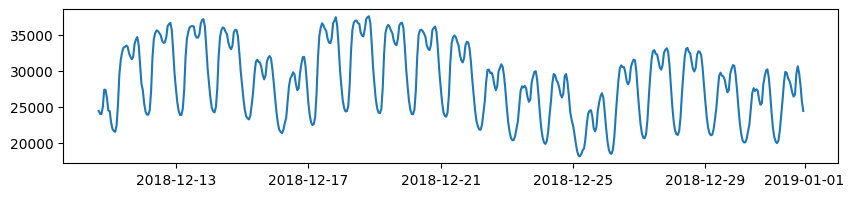

In [7]:
fig, axs = plt.subplots(len(target_columns), 1, figsize=(10, 2 * len(target_columns)), squeeze=False)
for ax, target_column in zip(axs, target_columns):
    ax[0].plot(input_df[timestamp_column], input_df[target_column])

### Set up zero shot model
The TTM model is hosted on [Hugging Face](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is retrieved by the wrapper, `TinyTimeMixerForPrediction`. We have one input channel in this example.

In [8]:
# Instantiate the model.
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",  # Name of the model on Hugging Face
    num_input_channels=len(target_columns),  # tsp.num_input_channels
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

### Create a forecasting pipeline

Set up the forecasting pipeline with the model, setting `frequency` given our knowledge of the sample frequency. In this example we set `explode_forecasts` to `False`, which keeps each sequence of predictions in a list within the dataframe cells. We then make a forecast on the dataset.

In [9]:
# Create a pipeline.
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=False,
    freq="h",
    device=device,  # Specify your local GPU or CPU.
)

# Make a forecast on the target column given the input data.
zeroshot_forecast = pipeline(input_df)
zeroshot_forecast.tail()

Device set to use cpu


,time,total load actual_prediction,total load actual
0,2018-12-31 23:00:00+01:00,"[23465.3671875, 22127.962890625, 21162.0644531...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


### Plot predictions along with the historical data.

The predicted series picks up where the historical data ends, and we can see that it predicts a continuation of the cyclical pattern and an upward trend.

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


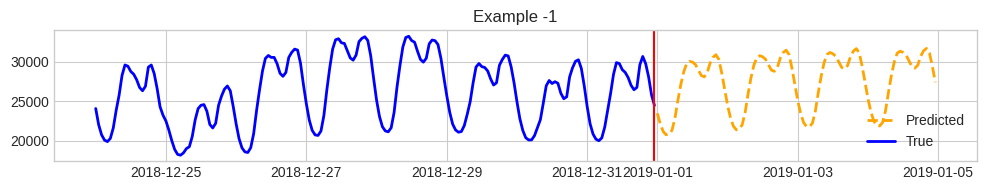

In [11]:
# Plot the historical data and predicted series.
plot_predictions(
    input_df=input_df,
    predictions_df=zeroshot_forecast,
    freq="h",
    timestamp_column=timestamp_column,
    channel=target_column,
    indices=[-1],
    num_plots=1,
)